<a href="https://colab.research.google.com/github/iu5git/Deep-learning/blob/main/notebooks/Text_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа №7

# Задание

Выбрать свой корпус текста и обучить последовательно на нём три архитектуры нейронных сетей на
задаче Next Token Prediction (предсказание следующего токена).

Архитектуры:
* Одномерная свёрточная нейронная сеть
* Рекуррентная нейронная сеть
* Трансформер кодировщик

Визуализировать полученное векторное представление токенов. Сохранить модели в формате onnx.

Дописать код для генерации текста по входной последовательности.

В качестве примера приводится обучение на русском корпусе текста - произведении
Ф.М. Достоевского "Преступление и наказание".

Отчет должен содержать: титульный лист, задание с вариантом корпуса текста, скриншоты и краткие пояснения по каждому этапу лабораторной работы, визуализация векторного представления.


# Контрольные вопросы
1. Предобработка текста
2. Архитектура трансформер
3. Удаление шумовых слов
4. Стемминг и лемматизация
5. Что такое эмбеддинг?

# Выполнение лабораторной работы

## Установка зависимостей

In [ ]:
!pip install tensorflow==2.7.0

In [ ]:
!pip install sentencepiece
!pip install umap-learn
!pip install gdown

     |████████████████████████████████| 1.2 MB 5.8 MB/s 
     |████████████████████████████████| 86 kB 3.3 MB/s 
     |████████████████████████████████| 1.1 MB 35.8 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82708 sha256=bda4c7af73b7631d99f4975e7dca7731fcbf7dffe91fa995253d0e2ac8a11797
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=5c23f5b4c6eafd8dedeededb2c6973cbec05688b1e3f69326641611ea2997c64
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
Successfully built umap-learn pynndescent


## Подключение библиотек

In [ ]:
from string import punctuation
import math
import time
import os

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from umap import UMAP
import sentencepiece as spm

import torch
import torch.nn as nn
import torch.nn.functional as F

%matplotlib inline

## Где взять датасеты
* https://nlpub.ru/Ресурсы - русские наборы данных

* https://huggingface.co/datasets - мультиязычные наборы данных

* https://avidreaders.ru/books/ - книги в txt 

* https://z-lib.org/ - книги в pdf, txt

* https://pdftotext.com/ - онлайн конвертер из pdf в txt

## Загрузка необработанного корпуса

In [ ]:
!gdown --id 1MO6aev-2UUpZlwF0o4ZVGvQLi1YfZhck

Downloading...
From: https://drive.google.com/uc?id=1MO6aev-2UUpZlwF0o4ZVGvQLi1YfZhck
To: /content/prestuplenie-i-nakazanie.txt
100% 1.28M/1.28M [00:00<00:00, 79.7MB/s]


## Очистка корпуса от пунктуации

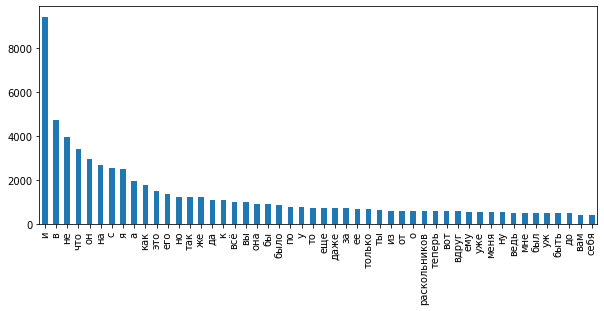

In [ ]:
def filter_punctuation(x):
    table = str.maketrans('', '', punctuation)
    x = map(lambda x: x.lower(), x)
    x = map(lambda x: x.translate(table), x)
    x = filter(lambda x: len(x)>0, x)
    return list(x)

FILENAME = 'prestuplenie-i-nakazanie.txt' 
corpus = []
# encoding может быть один из ['ascii', 'utf-8', 'cp1251']
with open(FILENAME, 'r',
          encoding='cp1251') as f:
    for line in f:
        corpus.extend(list(filter(lambda x: len(x)>0, line.split())))

corpus = filter_punctuation(corpus)
with open('corpus.txt', 'w') as f:
    f.write('\n'.join(corpus))
corpus_df = pd.Series(corpus)
corpus_df.value_counts().head(50).plot(kind='bar', figsize=(10, 4))

## Вывод наиболее частых слов

In [ ]:
pd.Series(corpus).value_counts()

и               9435
в               4716
не              3971
что             3400
он              2962
                ... 
относительны       1
способностям       1
разрушители        1
преступают         1
aug                1
Length: 31090, dtype: int64

## Обучение токенизатора на корпусе текста
Используется алгоритм [WordPiece](https://paperswithcode.com/method/wordpiece)


In [ ]:
spm.SentencePieceTrainer.train(input='corpus.txt', model_prefix='m',
                               vocab_size=10000)

## Проверка токенизатора 

In [ ]:
sp = spm.SentencePieceProcessor(model_file='m.model')
prompt = 'это пример токенизации текста'
print(sp.encode_as_ids(prompt)) # == sp.encode 
print(sp.encode_as_pieces(prompt))

[31, 2159, 43, 909, 73, 1200, 2542, 1581, 4]
['▁это', '▁пример', '▁то', 'ке', 'ни', 'за', 'ции', '▁текст', 'а']


## Получение словаря токенов

In [ ]:
vocabs = [[sp.id_to_piece(id), id] for id in range(sp.get_piece_size())]
vocabs[:20]

[['<unk>', 0],
 ['<s>', 1],
 ['</s>', 2],
 ['▁и', 3],
 ['а', 4],
 ['е', 5],
 ['▁в', 6],
 ['▁', 7],
 ['и', 8],
 ['▁не', 9],
 ['▁что', 10],
 ['▁с', 11],
 ['▁на', 12],
 ['й', 13],
 ['▁он', 14],
 ['у', 15],
 ['о', 16],
 ['я', 17],
 ['▁я', 18],
 ['м', 19]]

## Создание набора данных для задачи Next Token Prediction

In [ ]:
def get_window(x):
    XX.append(x.values.copy())
    return 0

WINDOW_SIZE = 16
XX = []
corpus_df = pd.DataFrame(np.concatenate(sp.encode(corpus)))
corpus_df.columns = ['token_ids']
corpus_df['ids'] = corpus_df['token_ids'].factorize(sort=True)[0]
corpus_df['ids'].rolling(WINDOW_SIZE+1).apply(get_window)
table = corpus_df[['token_ids', 'ids']].\
                 drop_duplicates().\
                 sort_values(['ids'], ascending=True).\
                 values
ids2token_ids = {v:k for k,v  in table}

In [ ]:
data = np.uint16(XX)
X = data[:, :WINDOW_SIZE].copy()
y = data[:, WINDOW_SIZE:].copy()

indexes = np.random.permutation(y.size)
X = X[indexes].copy()
y = y[indexes].copy()
assert np.unique(X).size == np.unique(y).size, \
    'Уменьшите размер словаря при обучении токенизатора'

## Обучение в Keras (прототипирование)

In [ ]:
import tensorflow as tf

inp = tf.keras.layers.Input((WINDOW_SIZE,))
x = tf.keras.layers.Embedding(np.unique(X).size, output_dim=50)(inp)
#x = tf.keras.layers.LSTM(128, return_sequences=False)(x)
#x = tf.keras.layers.Lambda(lambda xx: tf.transpose(xx, perm=[0, 2, 1]))(x)
x = tf.keras.layers.Conv1D(128, (5,), strides=(2,), activation='relu')(x)
x = tf.keras.layers.Conv1D(256, (5,), strides=(2,), activation='relu')(x)
#x = tf.keras.layers.Lambda(lambda xx: tf.transpose(xx, perm=[0, 2, 1]))(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
out = tf.keras.layers.Dense(np.unique(y).size, activation='softmax')(x)

model = tf.keras.models.Model(inp, out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16)]              0         
                                                                 
 embedding (Embedding)       (None, 16, 50)            499300    
                                                                 
 conv1d (Conv1D)             (None, 6, 128)            32128     
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 256)            164096    
                                                                 
 global_average_pooling1d (G  (None, 256)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 9986)              2566402   
                                                             

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',
              metrics=['accuracy', tf.keras.metrics.SparseTopKCategoricalAccuracy(5)])
#model = tf.keras.models.load_model('model.h5')

In [ ]:
tf.keras.backend.set_value(model.optimizer.lr, 2e-3)
model.fit(X, y, validation_split=0.0, epochs=20, batch_size=1024)

Epoch 1/20
276/276 [==============================] - 12s 42ms/step - loss: 6.7840 - accuracy: 0.0391 - sparse_top_k_categorical_accuracy: 0.1293
Epoch 2/20
276/276 [==============================] - 11s 39ms/step - loss: 6.6346 - accuracy: 0.0432 - sparse_top_k_categorical_accuracy: 0.1377
Epoch 3/20
276/276 [==============================] - 10s 38ms/step - loss: 6.4858 - accuracy: 0.0473 - sparse_top_k_categorical_accuracy: 0.1466
Epoch 4/20
276/276 [==============================] - 10s 38ms/step - loss: 6.3192 - accuracy: 0.0518 - sparse_top_k_categorical_accuracy: 0.1563
Epoch 5/20
276/276 [==============================] - 10s 37ms/step - loss: 6.1178 - accuracy: 0.0562 - sparse_top_k_categorical_accuracy: 0.1659
Epoch 6/20
276/276 [==============================] - 10s 37ms/step - loss: 5.8645 - accuracy: 0.0625 - sparse_top_k_categorical_accuracy: 0.1783
Epoch 7/20
276/276 [==============================] - 10s 38ms/step - loss: 5.5494 - accuracy: 0.0728 - sparse_top_k_categor

In [ ]:
model.save('model.h5')

In [ ]:
model.get_weights()[0].shape

(9986, 50)

In [ ]:
batch_size = 1024
preds = []
for i in tqdm(range(X.shape[0]//batch_size+1)):
    preds.append(model.predict(X[i*batch_size:(i+1)*batch_size].copy()).\
                 argsort(axis=-1)[:, -5:].copy())
preds = np.concatenate(preds)

  0%|          | 0/276 [00:00<?, ?it/s]

In [ ]:
for i in range(preds.shape[1]):
    corpus_df['pred@%d'%(i+1)] = -1
    corpus_df.loc[WINDOW_SIZE:, 'pred@%d'%(i+1)] = preds[:,-i]
corpus_df.head(50)

,token_ids,ids,pred@1,pred@2,pred@3,pred@4,pred@5
0,2519,2514,-1,-1,-1,-1,-1
1,2731,2725,-1,-1,-1,-1,-1
2,262,260,-1,-1,-1,-1,-1
3,13,11,-1,-1,-1,-1,-1
4,42,40,-1,-1,-1,-1,-1
5,1344,1339,-1,-1,-1,-1,-1
6,445,442,-1,-1,-1,-1,-1
7,3,1,-1,-1,-1,-1,-1
8,1110,1105,-1,-1,-1,-1,-1
9,507,503,-1,-1,-1,-1,-1


In [ ]:
for col in corpus_df.columns[-preds.shape[1]:]:
    corpus_df[col] = corpus_df[col].apply(lambda x: ids2token_ids.get(x, -1))

In [ ]:
sp.decode(corpus_df['pred@1'].tolist()[WINDOW_SIZE:])
#(corpus_df.token_ids==corpus_df[corpus_df.columns[-preds.shape[1]:]])

'авдотья словамлосьу буд особенно иы первы социальныму подся странно дама ник изий выоаго ту минутест уме голов совершенно предлага иом собственно какуюам иногут хозяйк межб ним что зате александровн на2сь оня как ихародя я блудниц ились себя не и сй ожидании на безй49 даертже будуще вниманиекуомч убиляконечно к в умеи мармеладовюыяхто к часть посооку комнату углу быости не пушкинотчасть время у на евангели  послышалеет они больнывшийтои время на он разговордатьм и соня какие в что минут мне не да так то дал я вяа один он коль не порог с49еишь бледно вилим большо засмеял в от петербургскися всегда неже да не и у какне что в по какть ицеа что с начала квартиру ков зловто верите что дикее обществ работникуда котор иек на ягоого нашел пожалуй переулок вов точу моглвидишьи так но вы он хорошо написапри того не второй иии признакочки газета и вы теме что я не давестис с он и положилмосьсти и него вонто прий  вер видитеий сами рукасмотря на пишет ее и даan39 см на одномуся ивановн я существу

In [ ]:
#from sklearn.decomposition import PCA
embeddings = UMAP(n_components=2, random_state=2).\
                                          fit_transform(model.get_weights()[0])

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


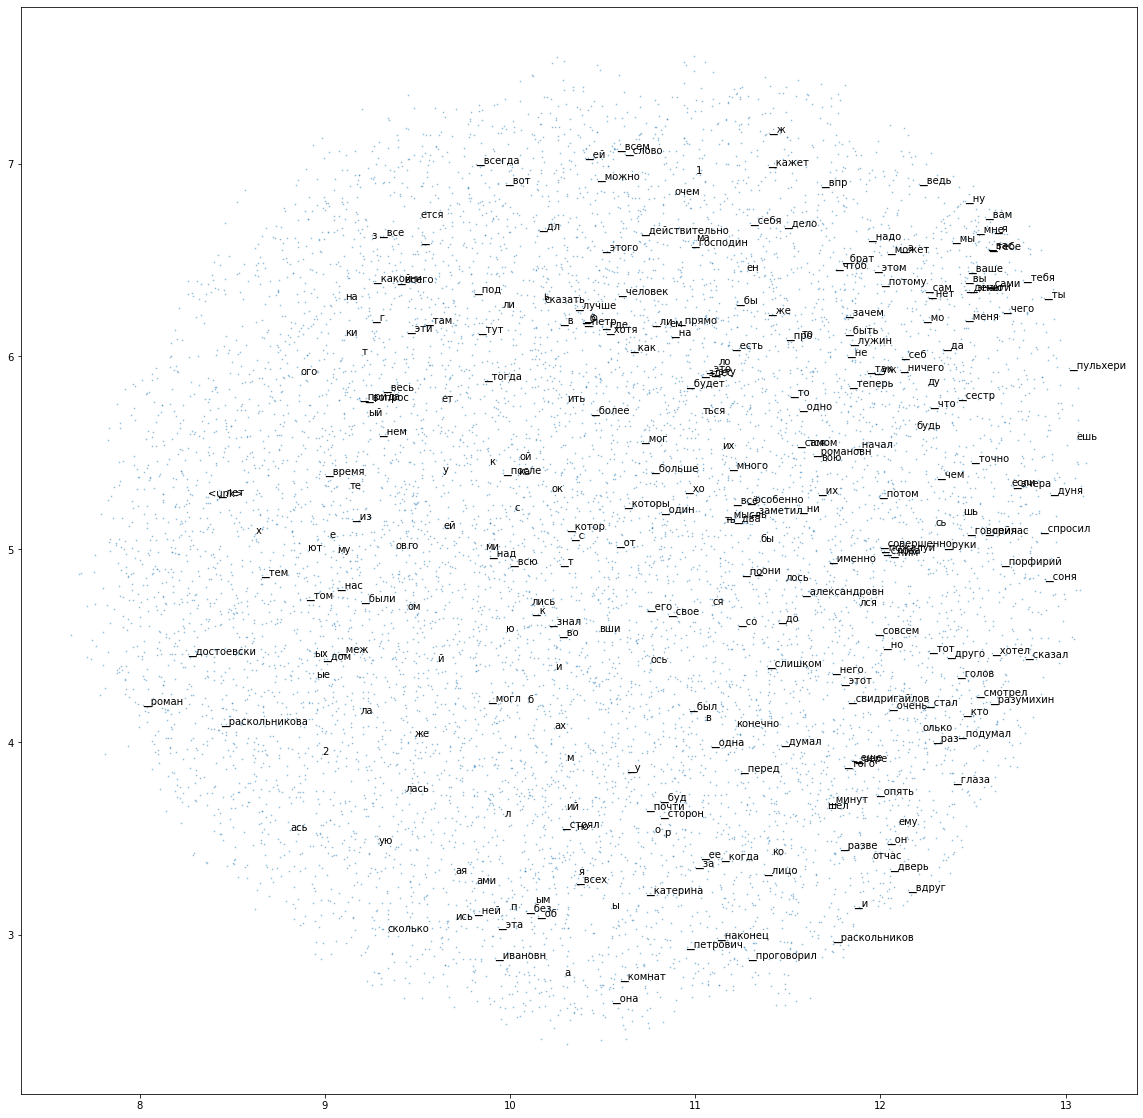

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.scatter(embeddings[:, 0], embeddings[:, 1], s=0.5, alpha=0.4)

whitelist = frozenset(corpus_df.token_ids.value_counts().index[:300].values)
for i, txt in enumerate(embeddings):
    token_id = ids2token_ids[i]
    if token_id not in whitelist:
        continue
    ax.annotate(vocabs[token_id][0],
                (embeddings[i][0], embeddings[i][1]))
plt.savefig('vecs.svg')

## Обучение в Pytorch
пример основан на

https://github.com/pytorch/examples/tree/master/word_language_model

In [ ]:
class ConvModel(nn.Module):
    """Container module with an encoder, a convolutional module, and a decoder."""

    def __init__(self, ntoken, ninp, nhid, dropout=0.1, tie_weights=False):
        super(ConvModel, self).__init__()
        self.ntoken = ntoken
        self.drop = nn.Dropout(dropout)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.conv = nn.Sequential(
                    nn.Conv1d(ninp, nhid//2, 5, stride=3, padding=2, dilation=1),
                    nn.ReLU(),
                    nn.Conv1d(nhid//2, nhid, 5, stride=3, padding=2, dilation=1),
                    nn.ReLU(),
                    nn.Conv1d(nhid, nhid*2, 5, stride=3, padding=2, dilation=1),
                    nn.ReLU(),
                    )
        self.decoder = nn.Linear(nhid*2, ntoken)

        self.init_weights()

        self.nhid = nhid
        self.model_type = 'Conv'

    def init_weights(self):
        initrange = 0.1
        nn.init.uniform_(self.encoder.weight, -initrange, initrange)
        nn.init.zeros_(self.decoder.bias)
        nn.init.uniform_(self.decoder.weight, -initrange, initrange)

    def forward(self, inputs):
        emb = self.drop(self.encoder(inputs))
        emb = emb.transpose(2, 1)
        output = self.conv(emb)
        #print(output.size())
        output = self.drop(output)
        output = output.transpose(2, 1)
        decoded = self.decoder(output)
        #print(decoded.size())
        decoded = decoded.view(-1, self.ntoken)
        return F.log_softmax(decoded, dim=1)


class RNNModel(nn.Module):
    """Container module with an encoder, a recurrent module, and a decoder."""

    def __init__(self, rnn_type, ntoken, ninp, nhid, nlayers, dropout=0.1, tie_weights=False):
        super(RNNModel, self).__init__()
        self.ntoken = ntoken
        self.drop = nn.Dropout(dropout)
        self.encoder = nn.Embedding(ntoken, ninp)
        if rnn_type in ['LSTM', 'GRU']:
            self.rnn = getattr(nn, rnn_type)(ninp, nhid, nlayers, dropout=dropout)
        else:
            try:
                nonlinearity = {'RNN_TANH': 'tanh', 'RNN_RELU': 'relu'}[rnn_type]
            except KeyError:
                raise ValueError( """An invalid option for `--model` was supplied,
                                 options are ['LSTM', 'GRU', 'RNN_TANH' or 'RNN_RELU']""")
            self.rnn = nn.RNN(ninp, nhid, nlayers, nonlinearity=nonlinearity, dropout=dropout)
        self.decoder = nn.Linear(nhid, ntoken)

        # Optionally tie weights as in:
        # "Using the Output Embedding to Improve Language Models" (Press & Wolf 2016)
        # https://arxiv.org/abs/1608.05859
        # and
        # "Tying Word Vectors and Word Classifiers: A Loss Framework for Language Modeling" (Inan et al. 2016)
        # https://arxiv.org/abs/1611.01462
        if tie_weights:
            if nhid != ninp:
                raise ValueError('When using the tied flag, nhid must be equal to emsize')
            self.decoder.weight = self.encoder.weight

        self.init_weights()

        self.rnn_type = rnn_type
        self.nhid = nhid
        self.nlayers = nlayers

    def init_weights(self):
        initrange = 0.1
        nn.init.uniform_(self.encoder.weight, -initrange, initrange)
        nn.init.zeros_(self.decoder.bias)
        nn.init.uniform_(self.decoder.weight, -initrange, initrange)

    def forward(self, input, hidden):
        emb = self.drop(self.encoder(input))
        output, hidden = self.rnn(emb, hidden)
        output = self.drop(output)
        decoded = self.decoder(output)
        decoded = decoded.view(-1, self.ntoken)
        return F.log_softmax(decoded, dim=1), hidden

    def init_hidden(self, bsz):
        weight = next(self.parameters())
        if self.rnn_type == 'LSTM':
            return (weight.new_zeros(self.nlayers, bsz, self.nhid),
                    weight.new_zeros(self.nlayers, bsz, self.nhid))
        else:
            return weight.new_zeros(self.nlayers, bsz, self.nhid)

# Temporarily leave PositionalEncoding module here. Will be moved somewhere else.
class PositionalEncoding(nn.Module):
    r"""Inject some information about the relative or absolute position of the tokens in the sequence.
        The positional encodings have the same dimension as the embeddings, so that the two can be summed.
        Here, we use sine and cosine functions of different frequencies.
    .. math:
        \text{PosEncoder}(pos, 2i) = sin(pos/10000^(2i/d_model))
        \text{PosEncoder}(pos, 2i+1) = cos(pos/10000^(2i/d_model))
        \text{where pos is the word position and i is the embed idx)
    Args:
        d_model: the embed dim (required).
        dropout: the dropout value (default=0.1).
        max_len: the max. length of the incoming sequence (default=5000).
    Examples:
        >>> pos_encoder = PositionalEncoding(d_model)
    """

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        r"""Inputs of forward function
        Args:
            x: the sequence fed to the positional encoder model (required).
        Shape:
            x: [sequence length, batch size, embed dim]
            output: [sequence length, batch size, embed dim]
        Examples:
            >>> output = pos_encoder(x)
        """

        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerModel(nn.Module):
    """Container module with an encoder, a recurrent or transformer module, and a decoder."""

    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.1):
        super(TransformerModel, self).__init__()
        try:
            from torch.nn import TransformerEncoder, TransformerEncoderLayer
        except:
            raise ImportError('TransformerEncoder module does not exist in PyTorch 1.1 or lower.')
        self.model_type = 'Transformer'
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.ninp = ninp
        self.decoder = nn.Linear(ninp, ntoken)

        self.init_weights()

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        # https://github.com/pytorch/pytorch/issues/28508
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        nn.init.uniform_(self.encoder.weight, -initrange, initrange)
        nn.init.zeros_(self.decoder.bias)
        nn.init.uniform_(self.decoder.weight, -initrange, initrange)

    def forward(self, src, has_mask=True):
        if has_mask:
            device = src.device
            if self.src_mask is None or self.src_mask.size(0) != len(src):
                mask = self._generate_square_subsequent_mask(len(src)).to(device)
                self.src_mask = mask
        else:
            self.src_mask = None
        #src = src.type(torch.int64)
        
        src = self.encoder(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        output = self.decoder(output)
        return F.log_softmax(output, dim=-1)

In [ ]:
###############################################################################
# Training code
###############################################################################

def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""

    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)


# get_batch subdivides the source data into chunks of length args.bptt.
# If source is equal to the example output of the batchify function, with
# a bptt-limit of 2, we'd get the following two Variables for i = 0:
# ┌ a g m s ┐ ┌ b h n t ┐
# └ b h n t ┘ └ c i o u ┘
# Note that despite the name of the function, the subdivison of data is not
# done along the batch dimension (i.e. dimension 1), since that was handled
# by the batchify function. The chunks are along dimension 0, corresponding
# to the seq_len dimension in the LSTM.

def get_batch(source, i):
    seq_len = min(bptt, len(y) - 1 - i)
    return torch.LongTensor(X[i:i+seq_len].astype(np.int32)).to(device), \
           torch.LongTensor(y[i:i+seq_len].astype(np.int32)).to(device)


def evaluate(data_source):
    # Turn on evaluation mode which disables dropout.
    model.eval()
    total_loss = 0.
    ntokens = np.unique(y).size
    model_types = frozenset(['Transformer', 'Conv'])

    if model_type not in model_types:
        hidden = model.init_hidden(WINDOW_SIZE)
    with torch.no_grad():
        for i in range(0, y.size - 1, bptt):
            data, targets = get_batch(y, i)
            if model_type == 'Transformer':
                output = model(data)
                output = output[:, -1, :]
            elif model_type == 'Conv':
                output = model(data)
                output = output.view(data.size()[0], -1, ntokens)[:, -1]
            else:
                output, hidden = model(data, hidden)
                hidden = repackage_hidden(hidden)
                output = output.view(-1, WINDOW_SIZE, ntokens)[:, -1]
            #print(output.size())
            total_loss += len(data) * criterion(output, targets.squeeze(1)).item()
    return total_loss / (len(data_source) - 1)


def train(batch_size=128):
    # Turn on training mode which enables dropout.
    model.train()
    total_loss = 0.
    start_time = time.time()
    ntokens = np.unique(y).size
    model_types = frozenset(['Transformer', 'Conv'])
    if model_type not in model_types:
        hidden = model.init_hidden(WINDOW_SIZE)
    for batch, i in enumerate(range(0, y.size - 1, bptt)):
        data, targets = get_batch(y, i)
        # Starting each batch, we detach the hidden state from how it was previously produced.
        # If we didn't, the model would try backpropagating all the way to start of the dataset.
        model.zero_grad()
        if model_type == 'Transformer':
            output = model(data)
            #output = output.view(-1, ntokens)
            output = output[:, -1]
        elif model_type == 'Conv':
            output = model(data)
            output = output.view(data.size()[0], -1, ntokens)[:, -1]
        else:
            hidden = repackage_hidden(hidden)
            output, hidden = model(data, hidden)
            output = output.view(-1, WINDOW_SIZE, ntokens)[:, -1]
        loss = criterion(output, targets.squeeze(1))
        loss.backward()

        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        for p in model.parameters():
            p.data.add_(p.grad, alpha=-lr)

        total_loss += loss.item()

        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | lr {:02.2f} | ms/batch {:5.3f} | '
                    'loss {:5.2f} | ppl {:8.2f}'.format(
                epoch, batch, len(y) // bptt, lr,
                elapsed * 1000 / log_interval, cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()
        if dry_run:
            break


def export_onnx(path, batch_size, seq_len):
    print('The model is also exported in ONNX format at {}.'.format(os.path.realpath(path)))
    model.eval()
    dummy_input = torch.LongTensor(seq_len * batch_size).zero_().view(-1, seq_len).to(device)
    inputs = dummy_input
    model_types = frozenset(['Transformer', 'Conv'])
    if model_type not in model_types:
        hidden = model.init_hidden(WINDOW_SIZE)
        inputs = (dummy_input, hidden)
    torch.onnx.export(model, inputs, path, opset_version=10)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Обучение свёрточной модели Conv1d

In [ ]:
model = ConvModel(np.unique(y).size, 128, 192, 0.1).to(device)
criterion = nn.NLLLoss()
model

ConvModel(
  (drop): Dropout(p=0.1, inplace=False)
  (encoder): Embedding(9986, 128)
  (conv): Sequential(
    (0): Conv1d(128, 96, kernel_size=(5,), stride=(3,), padding=(2,))
    (1): ReLU()
    (2): Conv1d(96, 192, kernel_size=(5,), stride=(3,), padding=(2,))
    (3): ReLU()
    (4): Conv1d(192, 384, kernel_size=(5,), stride=(3,), padding=(2,))
    (5): ReLU()
  )
  (decoder): Linear(in_features=384, out_features=9986, bias=True)
)

In [ ]:
model_type = 'Conv'
lr = 1
bptt = 64
eval_batch_size = bptt
clip = 0.1
log_interval = 100
dry_run = False

### Вывод числа параметров

In [ ]:
print(*[(k, p.view(-1).size()[0]) for k, p in model.named_parameters()],
      sep='\n')
print('Всего: {:,}'.format(sum(p.view(-1).size()[0] for k, p in model.named_parameters())))

('encoder.weight', 1278208)
('conv.0.weight', 61440)
('conv.0.bias', 96)
('conv.2.weight', 92160)
('conv.2.bias', 192)
('conv.4.weight', 368640)
('conv.4.bias', 384)
('decoder.weight', 3834624)
('decoder.bias', 9986)
Всего: 5,645,730


### Проверка прямого прохода модели

In [ ]:
model(torch.ones((32, 16)).type(torch.int64).to(device)).size()

torch.Size([32, 9986])

### Замер времени прохождения по всему корпусу

In [ ]:
%%time
evaluate(y)

CPU times: user 7.8 s, sys: 18.5 ms, total: 7.81 s
Wall time: 7.81 s


9.208191113095348

### Обучение модели

In [ ]:
# Loop over epochs.
epochs = 40
best_val_loss = None
savefile = '%s_next_token.pt'%model_type

patience_max = 1
patience = 0
# At any point you can hit Ctrl + C to break out of training early.
try:
    for epoch in range(1, epochs+1):
        epoch_start_time = time.time()
        train()
        val_loss = evaluate(y)
        print('-' * 89)
        print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.3f} | '
                'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                           val_loss, math.exp(val_loss)))
        print('-' * 89)
        # Save the model if the validation loss is the best we've seen so far.
        if not best_val_loss or val_loss < best_val_loss:
            with open(savefile, 'wb') as f:
                torch.save(model, f)
            best_val_loss = val_loss
            patience = 0
        else:
            patience += 1
            if patience < patience_max: continue 
            with open(savefile, 'rb') as f:
                model = torch.load(f)
            # Anneal the learning rate if no improvement has been seen in the validation dataset.
            lr /= 2.0
            patience = 0
except KeyboardInterrupt:
    print('-' * 89)
    print('Exiting from training early')

| epoch   1 |   100/ 4408 batches | lr 1.00 | ms/batch 12.663 | loss  8.59 | ppl  5370.29
| epoch   1 |   200/ 4408 batches | lr 1.00 | ms/batch 10.465 | loss  7.48 | ppl  1774.78
| epoch   1 |   300/ 4408 batches | lr 1.00 | ms/batch 10.595 | loss  7.31 | ppl  1488.17
| epoch   1 |   400/ 4408 batches | lr 1.00 | ms/batch 10.477 | loss  7.22 | ppl  1371.41
| epoch   1 |   500/ 4408 batches | lr 1.00 | ms/batch 10.413 | loss  7.20 | ppl  1337.51
| epoch   1 |   600/ 4408 batches | lr 1.00 | ms/batch 10.513 | loss  7.14 | ppl  1266.34
| epoch   1 |   700/ 4408 batches | lr 1.00 | ms/batch 10.419 | loss  7.15 | ppl  1269.29
| epoch   1 |   800/ 4408 batches | lr 1.00 | ms/batch 10.414 | loss  7.17 | ppl  1294.89
| epoch   1 |   900/ 4408 batches | lr 1.00 | ms/batch 10.402 | loss  7.14 | ppl  1264.06
| epoch   1 |  1000/ 4408 batches | lr 1.00 | ms/batch 10.463 | loss  7.07 | ppl  1173.13
| epoch   1 |  1100/ 4408 batches | lr 1.00 | ms/batch 10.461 | loss  7.12 | ppl  1235.49
| epoch   

### Проверка качества, экспорт в ONNX

In [ ]:
# Загрузка лучшей модели.
with open(savefile, 'rb') as f:
    model = torch.load(f)
    # после загрузки параметры RNN находятся не в одном сегменте памяти
    # для помещения в один участок и ускорения прямого прохода
    # В настоящее время, только рекуррентная модель поддерживает flatten_parameters.
    if model_type in ['RNN_TANH', 'RNN_RELU', 'LSTM', 'GRU']:
        model.rnn.flatten_parameters()

# Финальная проверка качества
test_loss = evaluate(y)
print('=' * 89)
print('| End of training | test loss {:5.2f} | test ppl {:8.3f}'.format(
    test_loss, math.exp(test_loss)))
print('=' * 89)

onnx_export = '%s_next_token.onnx'%(model_type)
if len(onnx_export) > 0:
    # Экспортирование модели в формат ONNX
    export_onnx(onnx_export, batch_size=1, seq_len=WINDOW_SIZE)

| End of training | test loss  4.76 | test ppl  116.803
The model is also exported in ONNX format at /content/Conv_next_token.onnx.


### Получение эмбеддингов, проекция на 2D

In [ ]:
#from sklearn.decomposition import PCA
embeddings = list(model.encoder.parameters())[0].detach().cpu().numpy()

embeddings = UMAP(n_components=2, random_state=2).fit_transform(embeddings)

### Визуализация пространства эмбеддингов

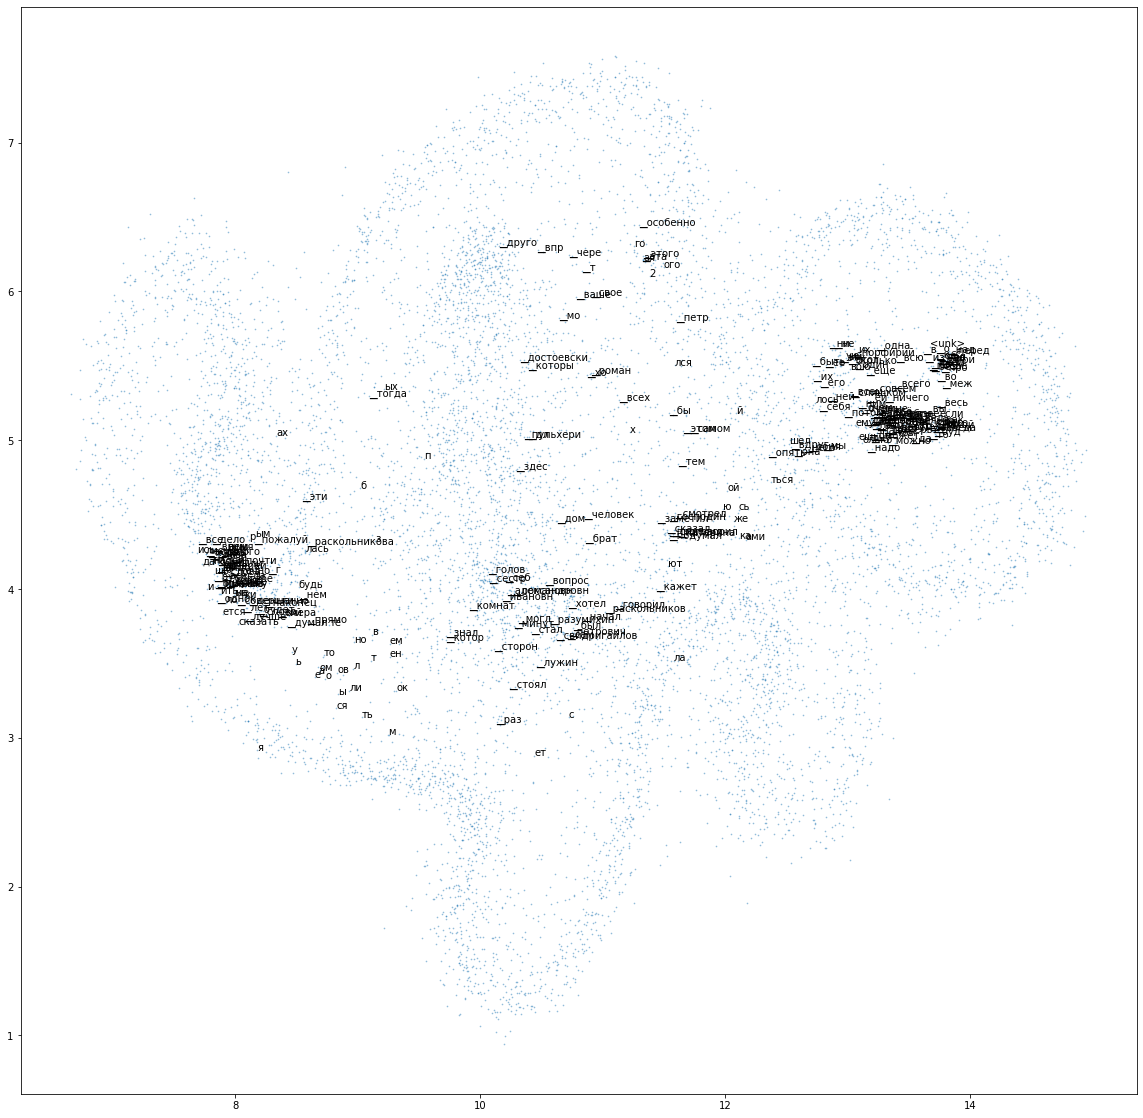

In [ ]:
# Визуализация обученных эмбеддингов
fig, ax = plt.subplots(figsize=(20, 20))
ax.scatter(embeddings[:, 0], embeddings[:, 1], s=0.5, alpha=0.4)

# берём 300 наиболее частых
whitelist = frozenset(corpus_df.token_ids.value_counts().index[:300].values)
for i, txt in enumerate(embeddings):
    token_id = ids2token_ids[i]
    if token_id not in whitelist:
        continue
    ax.annotate(vocabs[token_id][0],
                (embeddings[i][0], embeddings[i][1]))
plt.savefig('vecs_%s.svg'%model_type)

## Обучение рекуррентной модели LSTM

In [ ]:
model = RNNModel('LSTM', np.unique(y).size, 50, 256, 2, 0.1, False).to(device)
criterion = nn.NLLLoss()
model

RNNModel(
  (drop): Dropout(p=0.1, inplace=False)
  (encoder): Embedding(9986, 50)
  (rnn): LSTM(50, 256, num_layers=2, dropout=0.1)
  (decoder): Linear(in_features=256, out_features=9986, bias=True)
)

In [ ]:
model_type = 'LSTM'
lr=10
bptt = 1024
eval_batch_size = bptt
clip = 0.25
log_interval = 10
dry_run = False

### Вывод числа параметров

In [ ]:
print(*[(k, p.view(-1).size()[0]) for k, p in model.named_parameters()],
      sep='\n')
print('Всего: {:,}'.format(sum(p.view(-1).size()[0] for k, p in model.named_parameters())))

('encoder.weight', 499300)
('rnn.weight_ih_l0', 51200)
('rnn.weight_hh_l0', 262144)
('rnn.bias_ih_l0', 1024)
('rnn.bias_hh_l0', 1024)
('rnn.weight_ih_l1', 262144)
('rnn.weight_hh_l1', 262144)
('rnn.bias_ih_l1', 1024)
('rnn.bias_hh_l1', 1024)
('decoder.weight', 2556416)
('decoder.bias', 9986)
Всего: 3,907,430


### Замер времени прохождения по всему корпусу

In [ ]:
%%time
evaluate(y)

CPU times: user 44.3 s, sys: 4.51 s, total: 48.8 s
Wall time: 48.6 s


9.208568069354813

### Обучение модели

In [ ]:
# Loop over epochs.
epochs = 30
best_val_loss = None
savefile = '%s_next_token.pt'%model_type

# At any point you can hit Ctrl + C to break out of training early.
try:
    for epoch in range(1, epochs+1):
        epoch_start_time = time.time()
        train()
        val_loss = evaluate(y)
        print('-' * 89)
        print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.3f} | '
                'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                           val_loss, math.exp(val_loss)))
        print('-' * 89)
        # Save the model if the validation loss is the best we've seen so far.
        if not best_val_loss or val_loss < best_val_loss:
            with open(savefile, 'wb') as f:
                torch.save(model, f)
            best_val_loss = val_loss
        else:
            # Anneal the learning rate if no improvement has been seen in the validation dataset.
            lr /= 2.0
except KeyboardInterrupt:
    print('-' * 89)
    print('Exiting from training early')

| epoch   1 |    10/  275 batches | lr 10.00 | ms/batch 589.324 | loss  9.63 | ppl 15259.39
| epoch   1 |    20/  275 batches | lr 10.00 | ms/batch 531.428 | loss  7.80 | ppl  2438.67
| epoch   1 |    30/  275 batches | lr 10.00 | ms/batch 532.864 | loss  7.68 | ppl  2173.33
| epoch   1 |    40/  275 batches | lr 10.00 | ms/batch 534.221 | loss  7.36 | ppl  1565.68
| epoch   1 |    50/  275 batches | lr 10.00 | ms/batch 530.550 | loss  7.34 | ppl  1541.63
| epoch   1 |    60/  275 batches | lr 10.00 | ms/batch 533.868 | loss  7.23 | ppl  1384.38
| epoch   1 |    70/  275 batches | lr 10.00 | ms/batch 531.895 | loss  7.22 | ppl  1368.09
| epoch   1 |    80/  275 batches | lr 10.00 | ms/batch 533.349 | loss  7.21 | ppl  1348.90
| epoch   1 |    90/  275 batches | lr 10.00 | ms/batch 531.915 | loss  7.20 | ppl  1341.76
| epoch   1 |   100/  275 batches | lr 10.00 | ms/batch 534.349 | loss  7.11 | ppl  1227.59
| epoch   1 |   110/  275 batches | lr 10.00 | ms/batch 531.905 | loss  7.08 | p

### Проверка качества, экспорт в ONNX

In [ ]:
# Загрузка лучшей модели.
with open(savefile, 'rb') as f:
    model = torch.load(f)
    # после загрузки параметры RNN находятся не в одном сегменте памяти
    # для помещения в один участок и ускорения прямого прохода
    # В настоящее время, только рекуррентная модель поддерживает flatten_parameters.
    if model_type in ['RNN_TANH', 'RNN_RELU', 'LSTM', 'GRU']:
        model.rnn.flatten_parameters()

# Финальная проверка качества
test_loss = evaluate(y)
print('=' * 89)
print('| End of training | test loss {:5.2f} | test ppl {:8.3f}'.format(
    test_loss, math.exp(test_loss)))
print('=' * 89)

onnx_export = '%s_next_token.onnx'%(model_type)
if len(onnx_export) > 0:
    # Экспортирование модели в формат ONNX
    export_onnx(onnx_export, batch_size=1, seq_len=WINDOW_SIZE)

| End of training | test loss  4.57 | test ppl   96.635
The model is also exported in ONNX format at /content/LSTM_next_token.onnx.


/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_opset9.py:2123: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  "or define the initial states (h0/c0) as inputs of the model. ")


### Получение эмбеддингов, проекция на 2D

In [ ]:
#from sklearn.decomposition import PCA
embeddings = list(model.encoder.parameters())[0].detach().cpu().numpy()

embeddings = UMAP(n_components=2, random_state=2).fit_transform(embeddings)

### Визуализация пространства эмбеддингов

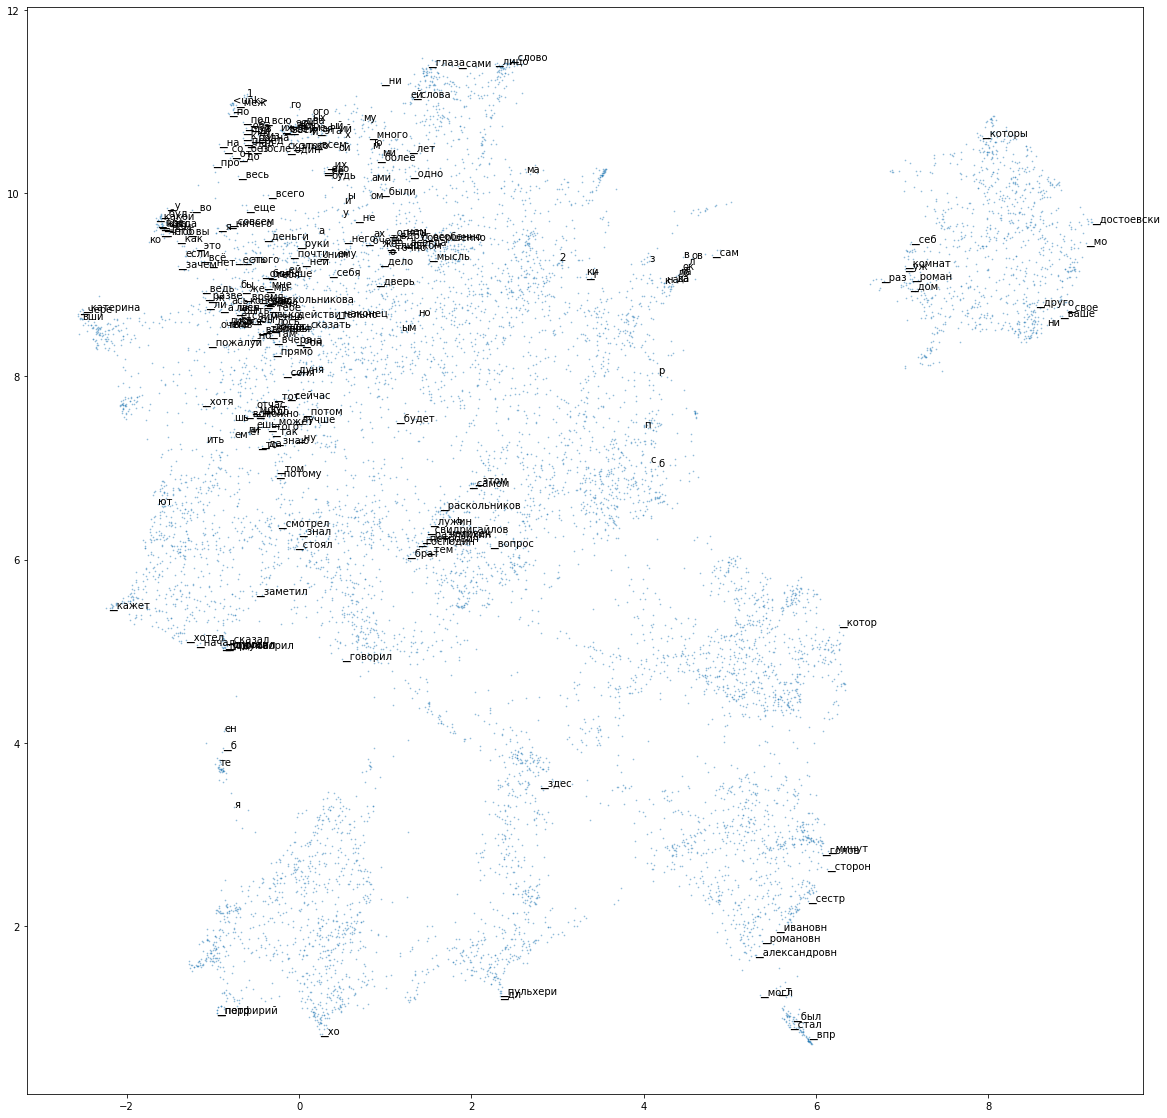

In [ ]:
# Визуализация обученных эмбеддингов
fig, ax = plt.subplots(figsize=(20, 20))
ax.scatter(embeddings[:, 0], embeddings[:, 1], s=0.5, alpha=0.4)

# берём 300 наиболее частых
whitelist = frozenset(corpus_df.token_ids.value_counts().index[:300].values)
for i, txt in enumerate(embeddings):
    token_id = ids2token_ids[i]
    if token_id not in whitelist:
        continue
    ax.annotate(vocabs[token_id][0],
                (embeddings[i][0], embeddings[i][1]))
plt.savefig('vecs_%s.svg'%model_type)

## Обучение модели self-attention

In [ ]:
model = TransformerModel(np.unique(y).size, 128+32, 4, 192, 2, 0.1).to(device)
# ntoken, ninp, nhead, nhid, nlayers, dropout
criterion = nn.NLLLoss()
model

TransformerModel(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=160, out_features=160, bias=True)
        )
        (linear1): Linear(in_features=160, out_features=192, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=192, out_features=160, bias=True)
        (norm1): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=160, out_features=160, bias=True)
        )
        

In [ ]:
model_type = 'Transformer'
lr = 2.0
bptt = 64
eval_batch_size = bptt
clip = 0.25
log_interval = 100
dry_run = False

### Вывод числа параметров

In [ ]:
print(*[(k, p.view(-1).size()[0]) for k, p in model.named_parameters()],
      sep='\n')
print('Всего: {:,}'.format(sum(p.view(-1).size()[0] for k, p in model.named_parameters())))

('transformer_encoder.layers.0.self_attn.in_proj_weight', 76800)
('transformer_encoder.layers.0.self_attn.in_proj_bias', 480)
('transformer_encoder.layers.0.self_attn.out_proj.weight', 25600)
('transformer_encoder.layers.0.self_attn.out_proj.bias', 160)
('transformer_encoder.layers.0.linear1.weight', 30720)
('transformer_encoder.layers.0.linear1.bias', 192)
('transformer_encoder.layers.0.linear2.weight', 30720)
('transformer_encoder.layers.0.linear2.bias', 160)
('transformer_encoder.layers.0.norm1.weight', 160)
('transformer_encoder.layers.0.norm1.bias', 160)
('transformer_encoder.layers.0.norm2.weight', 160)
('transformer_encoder.layers.0.norm2.bias', 160)
('transformer_encoder.layers.1.self_attn.in_proj_weight', 76800)
('transformer_encoder.layers.1.self_attn.in_proj_bias', 480)
('transformer_encoder.layers.1.self_attn.out_proj.weight', 25600)
('transformer_encoder.layers.1.self_attn.out_proj.bias', 160)
('transformer_encoder.layers.1.linear1.weight', 30720)
('transformer_encoder.lay

### Замер времени прохождения по всему корпусу

In [ ]:
%%time
evaluate(y)

CPU times: user 28.1 s, sys: 39.2 ms, total: 28.1 s
Wall time: 28 s


9.513940673104246

### Обучение модели

In [ ]:
# Loop over epochs.
epochs = 40
best_val_loss = None
savefile = '%s_next_token.pt'%model_type

patience_max = 2
patience = 0
# At any point you can hit Ctrl + C to break out of training early.
try:
    for epoch in range(1, epochs+1):
        epoch_start_time = time.time()
        train()
        val_loss = evaluate(y)
        print('-' * 89)
        print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.3f} | '
                'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                           val_loss, math.exp(val_loss)))
        print('-' * 89)
        # Save the model if the validation loss is the best we've seen so far.
        if not best_val_loss or val_loss < best_val_loss:
            with open(savefile, 'wb') as f:
                torch.save(model, f)
            best_val_loss = val_loss
            patience = 0
        else:
            patience += 1
            if patience < patience_max: continue 
            with open(savefile, 'rb') as f:
                model = torch.load(f)
            # Anneal the learning rate if no improvement has been seen in the validation dataset.
            lr /= 2.0
            patience = 0
except KeyboardInterrupt:
    print('-' * 89)
    print('Exiting from training early')

| epoch   1 |   100/ 4408 batches | lr 2.00 | ms/batch 21.431 | loss  7.82 | ppl  2478.05
| epoch   1 |   200/ 4408 batches | lr 2.00 | ms/batch 20.315 | loss  7.22 | ppl  1365.40
| epoch   1 |   300/ 4408 batches | lr 2.00 | ms/batch 20.220 | loss  7.04 | ppl  1142.81
| epoch   1 |   400/ 4408 batches | lr 2.00 | ms/batch 20.268 | loss  6.91 | ppl  1004.43
| epoch   1 |   500/ 4408 batches | lr 2.00 | ms/batch 20.392 | loss  6.83 | ppl   925.24
| epoch   1 |   600/ 4408 batches | lr 2.00 | ms/batch 20.260 | loss  6.75 | ppl   852.45
| epoch   1 |   700/ 4408 batches | lr 2.00 | ms/batch 21.003 | loss  6.71 | ppl   822.82
| epoch   1 |   800/ 4408 batches | lr 2.00 | ms/batch 20.308 | loss  6.67 | ppl   789.74
| epoch   1 |   900/ 4408 batches | lr 2.00 | ms/batch 20.318 | loss  6.62 | ppl   748.64
| epoch   1 |  1000/ 4408 batches | lr 2.00 | ms/batch 20.424 | loss  6.53 | ppl   683.76
| epoch   1 |  1100/ 4408 batches | lr 2.00 | ms/batch 20.370 | loss  6.55 | ppl   696.21
| epoch   

### Проверка качества, экспорт в ONNX

In [ ]:
# Загрузка лучшей модели.
with open(savefile, 'rb') as f:
    model = torch.load(f)
    # после загрузки параметры RNN находятся не в одном сегменте памяти
    # для помещения в один участок и ускорения прямого прохода
    # В настоящее время, только рекуррентная модель поддерживает flatten_parameters.
    if model_type in ['RNN_TANH', 'RNN_RELU', 'LSTM', 'GRU']:
        model.rnn.flatten_parameters()

# Финальная проверка качества
test_loss = evaluate(y)
print('=' * 89)
print('| End of training | test loss {:5.2f} | test ppl {:8.3f}'.format(
    test_loss, math.exp(test_loss)))
print('=' * 89)

onnx_export = '%s_next_token.onnx'%(model_type)
if len(onnx_export) > 0:
    # Экспортирование модели в формат ONNX
    export_onnx(onnx_export, batch_size=1, seq_len=WINDOW_SIZE)

| End of training | test loss  2.38 | test ppl   10.790
The model is also exported in ONNX format at /content/Transformer_next_token.onnx.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:179: TracerWarning: Using len to get tensor shape might cause the trace to be incorrect. Recommended usage would be tensor.shape[0]. Passing a tensor of different shape might lead to errors or silently give incorrect results.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:179: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:180: TracerWarning: Using len to get tensor shape might cause the trace to be incorrect. Recommended usage would be tensor.shape[0]. Passing a tensor of different shape might lead to errors or silently give incorrect results.
/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:325: UserWarning: Type can

### Получение эмбеддингов, проекция в 2D

In [ ]:
#from sklearn.decomposition import PCA
embeddings = list(model.encoder.parameters())[0].detach().cpu().numpy()

embeddings = UMAP(n_components=2, random_state=2).fit_transform(embeddings)

### Визуализация пространства эмбеддингов

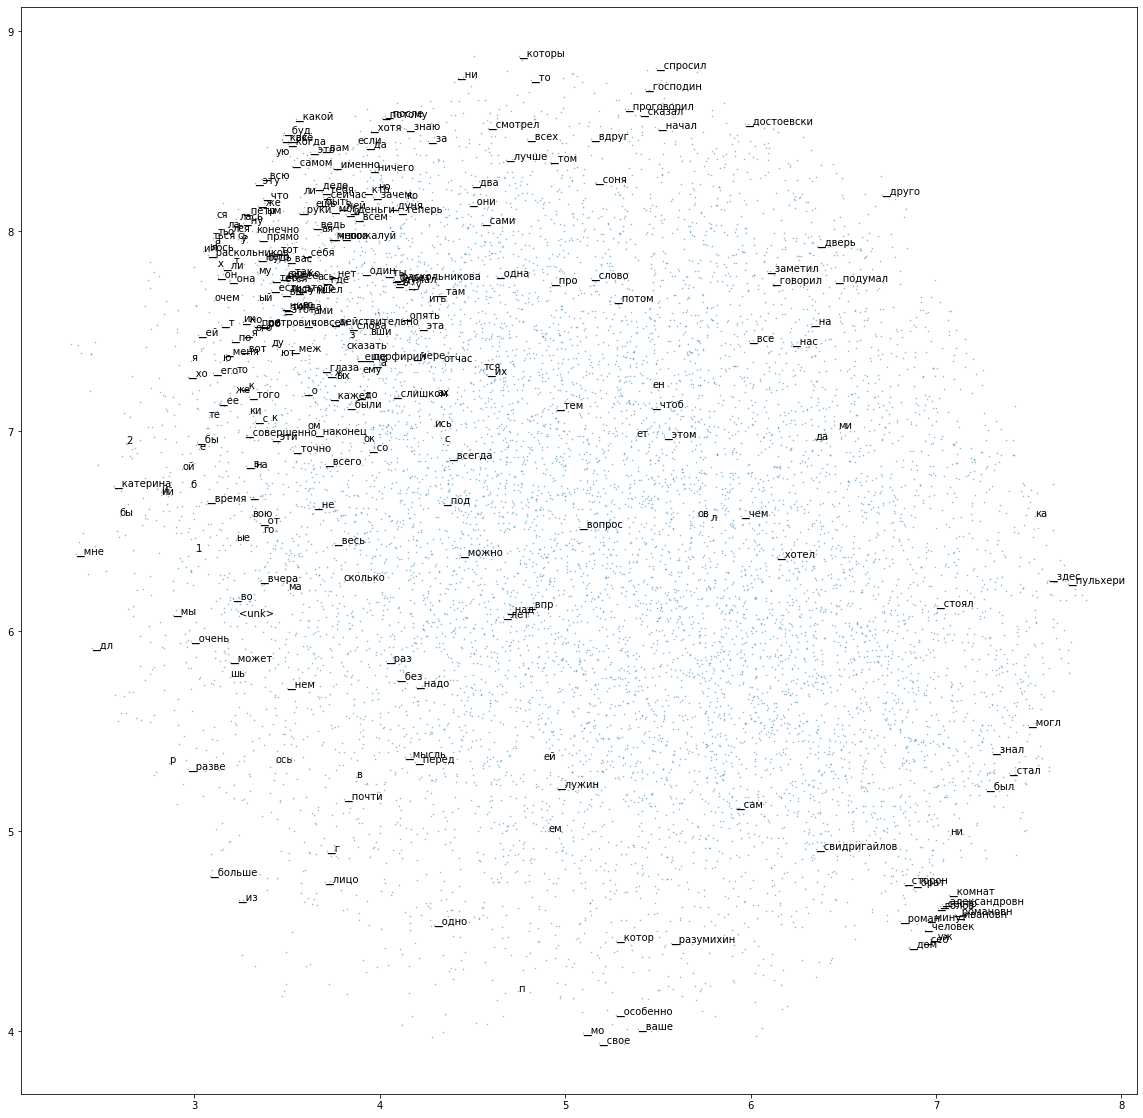

In [ ]:
# Визуализация обученных эмбеддингов
fig, ax = plt.subplots(figsize=(20, 20))
ax.scatter(embeddings[:, 0], embeddings[:, 1], s=0.5, alpha=0.4)

# берём 300 наиболее частых
whitelist = frozenset(corpus_df.token_ids.value_counts().index[:300].values)
for i, txt in enumerate(embeddings):
    token_id = ids2token_ids[i]
    if token_id not in whitelist:
        continue
    ax.annotate(vocabs[token_id][0],
                (embeddings[i][0], embeddings[i][1]))
plt.savefig('vecs_%s.svg'%model_type)